# Progetto Visualizzazione Scientifica - Accessibilità nelle scuole

### import librerie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.text import Text
import matplotlib.patches as mpatches
import geopandas as gpd
import mapclassify as mc
from shapely.geometry import Polygon, Point

data_dir = "./dataset/"
img_dir = "./img/"

## Funzioni utili ( private )

In [2]:
# Funzione che modifica i nomi delle colonne di "da_modificare" con i nomi delle corrispondenti colonne di "base"
def make_consistent(base, da_modificare):
    for i in range(min(base.columns.size, da_modificare.columns.size)):
        # check if columns name are equal
        if(base.columns[i] != da_modificare.columns[i]):
            # rename column
            da_modificare.rename(columns = {da_modificare.columns[i]:base.columns[i]}, inplace=True)

# Funzione che verifica che due dataset abbiano lo stesso numero di colonne e con gli stessi nomi 
def check_same_shape(a, b):
    size = min(a.columns.size, b.columns.size)
    return np.all(a.columns[:size] == b.columns[:size])

def get_province_by_region(regione, elenco_province):
    return elenco_province[elenco_province.regione == regione].sigla.to_numpy()
def get_scuole_by_province(province, elenco_scuole):
    return elenco_scuole[elenco_scuole.SIGLAPROVINCIA.isin(province)]

## Funzioni utili ( public )

In [3]:
def get_scuole_by_region(regione, elenco_scuole, elenco_province):
    return get_scuole_by_province(get_province_by_region(regione, elenco_province), elenco_scuole)

def cartina(get_dati_function, cmap, bins_size, regioni, title):
    
    # add data to italy dataset
    regioni['DATA'] = regioni.DEN_REG.apply(lambda x: get_dati_function(x))
    
    # get no data regions
    nodata = regioni[regioni.DATA == 0]
    regioni = regioni.drop(regioni[regioni.DATA == 0].index)
    
    # set up cartina
    fig, ax = plt.subplots(1, figsize=(8, 16))
    ax.set_axis_off()
    plt.title(title)
    
    # bins
    #bins = mc.Quantiles(regioni.DATA, k=bins_size).bins
    bins = np.linspace(regioni.DATA.min(), regioni.DATA.max(), bins_size)
    
    #plot
    regioni.plot(column='DATA', cmap=cmap, ax=ax, 
             edgecolor='black', linewidth=1, 
             scheme="User_Defined", 
             classification_kwds=dict(bins=bins),
             legend=True, legend_kwds={'title': "legend"}
    )
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    
    linspace = np.linspace(0, 100, bins_size)
    
    min = regioni.DATA.min()
    max = regioni.DATA.max()
    patches = []
    for i in range(bins_size):
        previous = min if i == 0 else bins[i - 1]
        patches.append(
            mpatches.Patch(
                color=sm.to_rgba(linspace[i]), 
                label=(
                    str(round(previous)) + ' - ' + str(round(bins[i])) + " %"
                )
            )
        )

    patches.append(mpatches.Patch(color='none'))
    patches.append(mpatches.Patch(color='gray', label='no data'))
    ax.legend(handles=patches, loc="best", prop={'size':9})

    nodata.plot(color='gray', ax=ax, edgecolor='black', linewidth=1)
    
    
def plot_bar_by_school_type(data):
    plt.figure(figsize=(5, 5))
    plt.ylim([0,100])
    names = ['Scuole elementari', 'Scuole medie', 'Scuole superiori']
    plt.bar(names, data, color='orange', width=0.5)

# Import DataSet

In [4]:
# ***************************** #
# ********* ELENCO ************ # 
# ***************************** #

elenco_scuole = pd.read_csv(data_dir + "elenco_scuole_italia.csv")

# ***************************** #
# ********* PROVINCE ********** # 
# ***************************** #


elenco_province = pd.read_csv(data_dir + "province.csv", encoding='latin-1')
elenco_regioni = elenco_province.regione.unique()

# ***************************** #
# ********** AMBIENTE ********* # 
# ***************************** #

a_1718 = pd.read_csv(data_dir + "ambiente_italia_1718.csv")
a_1819 = pd.read_csv(data_dir + "ambiente_italia_1819.csv")
a_2021 = pd.read_csv(data_dir + "ambiente_italia_2021.csv")
a_2122 = pd.read_csv(data_dir + "ambiente_italia_2122.csv")

# MODIFICHE
# drop last column in ambiente dataframes ( sembra poco rilevante )
a_1718.drop(columns=['AREAALTREMOTIVAZIONI'], inplace=True)
a_1819.drop(columns=['AREAALTREMOTIVAZIONI'])
a_2021.drop(columns=['ALTRECRITICITASPECIFICHE'], inplace=True)
a_2122.drop(columns=['ALTRECRITICITASPECIFICHE'], inplace=True)
# drop column in position 12 ( non coincidono tra annate e sempra poco rilevante )
a_1718.drop(columns=[a_1718.columns[12]], inplace=True)
a_1819.drop(columns=[a_1819.columns[12]], inplace=True)
a_2021.drop(columns=[a_2021.columns[12]], inplace=True)
a_2122.drop(columns=[a_2122.columns[12]], inplace=True)

# modifica nomi degli attributi 
make_consistent(a_2021, a_1819)
make_consistent(a_2021, a_1718)

# ***************************** #
# ****** RAGGIUNGIBILITÀ ****** # 
# ***************************** #
t_1516 = pd.read_csv(data_dir + "trasporti_italia_1516.csv")
t_1718 = pd.read_csv(data_dir + "trasporti_italia_1718.csv")
t_1819 = pd.read_csv(data_dir + "trasporti_italia_1819.csv")
t_2021 = pd.read_csv(data_dir + "trasporti_italia_2021.csv")
t_2122 = pd.read_csv(data_dir + "trasporti_italia_2122.csv")

# MODIFICHE
# drop last column ( "ALTRO", difficile da analizzare)
t_1516.drop(columns=[t_1516.columns[t_1516.columns.size - 1]], inplace=True)
t_1718.drop(columns=[t_1718.columns[t_1718.columns.size - 1]], inplace=True)
t_1819.drop(columns=[t_1819.columns[t_1819.columns.size - 1]], inplace=True)
t_2021.drop(columns=[t_2021.columns[t_2021.columns.size - 1]], inplace=True)
t_2122.drop(columns=[t_2122.columns[t_2122.columns.size - 1]], inplace=True)
# le annate 2121 e 2122 hanno in più una colonna alla fine relativa alla presenza di piste ciclabili

# modifica nomi degli attributi 
make_consistent(t_2021, t_1516)
make_consistent(t_2021, t_1718)
make_consistent(t_2021, t_1819)

# ***************************** #
# * BARRIERE ARCHITETTONICHE ** # 
# ***************************** #
ba_1718 = pd.read_csv(data_dir + "barriere_architettoniche_italia_1718.csv")
ba_1819 = pd.read_csv(data_dir + "barriere_architettoniche_italia_1819.csv")
ba_2021 = pd.read_csv(data_dir + "barriere_architettoniche_italia_2021.csv")
ba_2122 = pd.read_csv(data_dir + "barriere_architettoniche_italia_2122.csv")

# MODIFICHE
# drop last column ( "ALTRO", difficile da analizzare)
ba_1718.drop(columns=[ba_1718.columns[ba_1718.columns.size - 1]], inplace=True)
ba_1819.drop(columns=[ba_1819.columns[ba_1819.columns.size - 1]], inplace=True)
ba_2021.drop(columns=[ba_2021.columns[ba_2021.columns.size - 1]], inplace=True)
ba_2122.drop(columns=[ba_2122.columns[ba_2122.columns.size - 1]], inplace=True)

# modifica nomi degli attributi 
make_consistent(ba_2021, ba_1819)
make_consistent(ba_2021, ba_1718)



#####################################################################################


### PRINT STUFF
print('SCHEMA DATASET AMBIENTE', a_1819.columns)
print("\n\n\n")
print('SCHEMA DATASET RAGGIUNGIBILITÀ', t_1819.columns)
print("\n\n\n")
print('SCHEMA DATASET BARRIERE ARCHITETTONICHE', ba_1819.columns)
print("\n\n\n")
print('SCHEMA ELENCO SCUOLE', elenco_scuole.columns)
print("\n\n\n")
print('SCHEMA province', elenco_province.columns)


SCHEMA DATASET AMBIENTE Index(['ANNOSCOLASTICO', 'CODICESCUOLA', 'CODICEEDIFICIO',
       'CONTESTOSENZADISTURBI', 'VICINANZADISCARICA',
       'VICINANZAINDUSTRIEINQUINANTI', 'VICINANZAACQUEINQUINANTI',
       'VICINANZAFONTIINQUINAMENTOATMOSFERICO',
       'VICINANZAFONTIINQUINAMENTOACUSTICO',
       'VICINANZASORGENTIRADIAZIONIELETTROMAGNETICHE', 'VICINANZACIMITERI',
       'VICINANZAALTRIDISTURBI', 'ASSENZAPIAZZOLAADEGUATA', 'AREANONRECINTATA',
       'PRESENZAGRANDETRAFFICO', 'PRESENZATRANSITOFERROVIARIO',
       'PREESISTENZEINDUSTRIALIABBANDONATE', 'ZONAURBANADEGRADATA',
       'VICINANZAINDUSTRIEARISCHIO', 'AREAALTREMOTIVAZIONI'],
      dtype='object')




SCHEMA DATASET RAGGIUNGIBILITÀ Index(['ANNOSCOLASTICO', 'CODICESCUOLA', 'CODICEEDIFICIO', 'SCUOLABUS',
       'TRASPORTIPUBBLICIURBANI', 'TRASPORTIPUBBLICIINTERURBANI',
       'TRASPORTIFERROVIARI', 'MEZZIPRIVATI', 'TRASPORTODISABILI'],
      dtype='object')




SCHEMA DATASET BARRIERE ARCHITETTONICHE Index(['ANNOSCOLASTICO',

## codici tipo di scuola

In [5]:
licei = ['PC', 'PL', 'PS', 'SL']
istituti_tecnici = ['TA', 'TB', 'TD', 'TE', 'TF', 'TH', 'TL', 'TN']
istituti_professionali = ['RA', 'RB', 'RC', 'RE', 'RF', 'RH', 'RI', 'RM', 'RN', 'RS', 'RT', 'RV']
# area_artistica = ['SD', 'SM', 'SN', 'SR', 'ST']
media = ['MM']
elementari = ['EE']
istituto_comprensivo = ['IC']
superiori = ['IS']
# scuola_materna = ['AA']  togliamo
# magistrali = ['PM', 'PQ'] togliamo
# altri = ['VC', 'VE'] togliamo

codici_elementari = elementari + istituto_comprensivo
codici_medie = media + istituto_comprensivo
codici_superiori = superiori + istituti_professionali + istituti_tecnici + licei


######### CODICI DI INTERESSE #########
codici = codici_elementari + codici_medie + codici_superiori


###### query per selezionare solo le scuole con i codici di interesse ######
#elenco_scuole = elenco_scuole[elenco_scuole.CODICESCUOLA.str[2:4].isin(codici) == True]
print(elenco_scuole)


def get_elementari(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici_elementari)]
def get_medie(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici_medie)]
def get_superiori(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici_superiori)]

def get_scuole_di_interesse(df):
    return df[df.CODICESCUOLA.str[2:4].isin(codici)]


       ANNOSCOLASTICO CODICESCUOLA  CODICEEDIFICIO  CODICECOMUNE  \
0              202122   APAA810017      1090060033        109006   
1              202122   RMEE8DZ086       580013134         58001   
2              202122   GEAA838011       100250066         10025   
3              202122   BAAA846023       720061366         72006   
4              202122   BGIS033008       162190782         16219   
...               ...          ...             ...           ...   
61144          202122   SATF076019       651370502         65137   
61145          202122   BNMM84501L       620080201         62008   
61146          202122   UDAA83801B       300480004         30048   
61147          202122   TOAA89703L        11890003          1189   
61148          202122   CREE812013       191090001         19109   

       DESCRIZIONECOMUNE SIGLAPROVINCIA TIPOLOGIAINDIRIZZO  \
0                  FERMO             FM                Via   
1                 AFFILE             RM                Via 

# Dati utili

In [6]:
years_labels = ['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022'] 
#years_labels_from_1516 = ['2015-2016'] + years_labels
tipi_scuole_labels = ['Elementari', 'Medie', 'Superiori']

# Test geopandas

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
shape_regioni = gpd.read_file(filename=(data_dir + 'regioni_shape/regioni.shp'))

In [8]:
regioni = gpd.read_file(filename=(data_dir + 'regioni_shape/regioni.shp'))

def percentuale_servizi_igienici_disabili(regione):
    prov = elenco_province[elenco_province.regione == regione].sigla
    scuole = elenco_scuole[elenco_scuole.SIGLAPROVINCIA.isin(prov)].CODICESCUOLA
    if(len(scuole) == 0): return 0
    servizi_igienici = ba_2122[ba_2122.CODICESCUOLA.isin(scuole)].SERVIZIIGIENICISPECIFICINORMADISABILI
    servizi_igienici = servizi_igienici == 'SI'
    return servizi_igienici[servizi_igienici].size / len(scuole) * 100
"""

#regioni['SERVIZI_IGIENICI'] = percentuale_servizi_igienici_disabili('Lombardia')

regioni['SERVIZI_IGIENICI'] = regioni.DEN_REG.apply(lambda x: percentuale_servizi_igienici_disabili(x))

#regioni.loc[regioni.SERVIZI_IGIENICI == 0, "SERVIZI_IGIENICI"] = np.nan
nodata = regioni[regioni.SERVIZI_IGIENICI == 0]
regioni.drop(regioni[regioni.SERVIZI_IGIENICI == 0].index, inplace=True)

# set subplot and get figure and axis
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.title('Servizi igienici per disabili')
ax.set_axis_off()

cmap = plt.cm.coolwarm

bins = mc.Quantiles(regioni.SERVIZI_IGIENICI, k=10).bins

regioni.plot(column='SERVIZI_IGIENICI', cmap=cmap, ax=ax, 
             edgecolor='black', linewidth=1, 
             scheme="User_Defined", 
             classification_kwds=dict(bins=bins),
             legend=True, legend_kwds={'title': "legend"}
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))

linspace = np.linspace(0, 100, 10)
min = regioni.SERVIZI_IGIENICI.min()
max = regioni.SERVIZI_IGIENICI.max()
patches = []
for i in range(10):
    previous = min if i == 0 else bins[i - 1]
    patches.append(
        mpatches.Patch(
            color=sm.to_rgba(linspace[i]), 
            label=(
                str(round(previous)) + ' - ' + str(round(bins[i])) + " %"
            )
        )
    )

patches.append(mpatches.Patch(color='none'))
patches.append(mpatches.Patch(color='gray', label='no data'))
ax.legend(handles=patches, loc="best", prop={'size':9})
      
nodata.plot(color='gray', ax=ax, edgecolor='black', linewidth=1)


plt.savefig(img_dir + 'cartina_servizi_igienici.png')

"""

'\n\n#regioni[\'SERVIZI_IGIENICI\'] = percentuale_servizi_igienici_disabili(\'Lombardia\')\n\nregioni[\'SERVIZI_IGIENICI\'] = regioni.DEN_REG.apply(lambda x: percentuale_servizi_igienici_disabili(x))\n\n#regioni.loc[regioni.SERVIZI_IGIENICI == 0, "SERVIZI_IGIENICI"] = np.nan\nnodata = regioni[regioni.SERVIZI_IGIENICI == 0]\nregioni.drop(regioni[regioni.SERVIZI_IGIENICI == 0].index, inplace=True)\n\n# set subplot and get figure and axis\nfig, ax = plt.subplots(1, figsize=(8, 8))\nplt.title(\'Servizi igienici per disabili\')\nax.set_axis_off()\n\ncmap = plt.cm.coolwarm\n\nbins = mc.Quantiles(regioni.SERVIZI_IGIENICI, k=10).bins\n\nregioni.plot(column=\'SERVIZI_IGIENICI\', cmap=cmap, ax=ax, \n             edgecolor=\'black\', linewidth=1, \n             scheme="User_Defined", \n             classification_kwds=dict(bins=bins),\n             legend=True, legend_kwds={\'title\': "legend"}\n)\n\nsm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))\n\nlinspace = np.lins

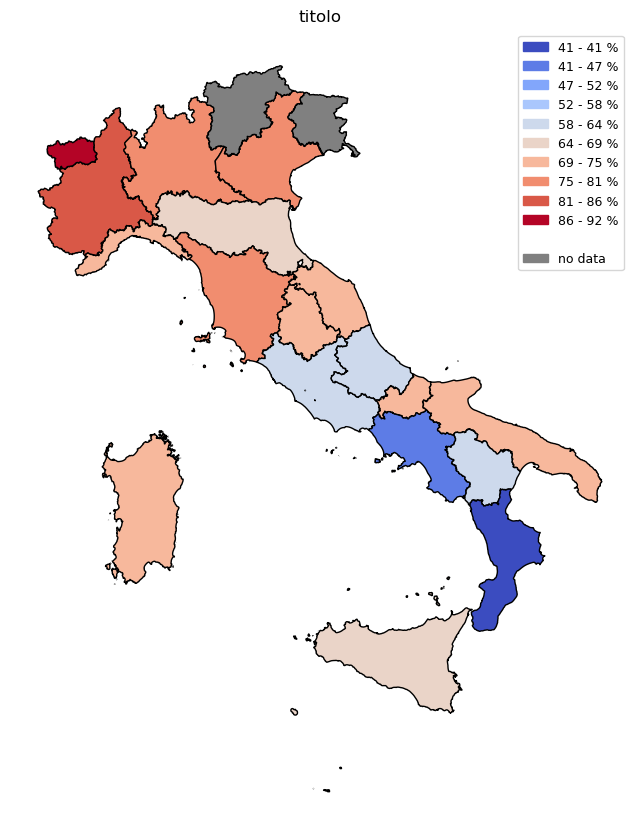

In [9]:
cartina(percentuale_servizi_igienici_disabili, plt.cm.coolwarm, 10, gpd.read_file(filename=(data_dir + 'regioni_shape/regioni.shp')), 'titolo')

# Le scuole nella città 
### Introduzione

La ricerca ha l'obiettivo di analizzare le scuole dal punto di vista dell'inserimento nelle città; ovvero come essere dialogano con l'infrastruttura di trasporto e con l'ambiente circostante.
Le analisi si articolano attraverso i seguenti temi:
- la raggiungibilità delle scuole mediante i mezzi di trasporto pubblici disponibili nella città. 
- l'ambiente in cui si trova la scuola, ovvero la vicinanza della scuola a fonti inquinanti di vario tipo, cimiteri, discariche, ecc.;
questo tema può anche diventare occasione di discutere la qualità e la distribuzione degli agenti inquinanti da un punto di vista pratico, ovvero legato ai luoghi che frequentiamo quotidianamente, piuttosto che da un punto di vista puramente scientifico.
- il superamento delle barriere architettoniche, ovvero la presenza di accorgimenti strutturali che consentono anche a persone con disabilità di fruire in modo completo dell'edificio e dei suoi servizi;
quest'ultimo punto consente di completare il tema della raggiungibilità.

La ricerca porterà le diverse regioni e provincie italiane a confronto, con lo scopo di evidenziare le zone di maggior criticità; queste saranno analizzate in modo approfondito, per identificare nel dettaglio le problematiche e come esse si sono evolute nel tempo.

I dati sono forniti dal ministero dell'istruzione alla seguente pagina: https://dati.istruzione.it/opendata/opendata/catalogo/elements1/?area=Edilizia%20Scolastica


# Raggiungibilità

- scuolabus
- urbani
- interurbani
- ferroviari


INTRODUZIONE:
- 1: Semplice line-chart in cui descriviamo l'andamento della percentuale di scuole raggiungibili per ogni tipo di mezzo pubblico; in questo modo per ogni anno vediamo in percentuale quante scuole sono raggiungibili con un certo mezzo, e vediamo nel tempo se questa percentuale è cambiata o meno; questo grafico ci permette di comprendere quali sono i mezzi presumibilmente più utilizzati per raggiungere le scuole.
- 2: Una cartina epr ogni mezzo, in cui per ogni regione vediamo la percentuale di scuole raggiungibili con quel mezzo; in questo modo possiamo capire come sono distribuiti i mezzi nelle regioni, se si tratta quindi di mezzi utilizzati in modo diffuso in tutta italia o se si concentrano in alcune regioni; la scala dei colori dovrebbe rimanere la stessa per tutte le cartine in modo da mantenere consistenza tra i valori.

barchart tipo mezzo o tipo scuola 
Probabilmente da queste due prime cartine non ricaveremo granché, ma credo abbia senso per farsi un idea generale


SITUAZIONE GENERALE:
- 3: si potrebbero fare delle cartine "riassuntive" che fotografano la situazione generale delle regioni: per ogni regione calcoliamo la percentuale di sucole raggiungibili con almeno un mezzo; potremmo fare una cartina per ogni "numero di mezzi minimi", quindi la cartina delle scuole raggiungibili da un mezzo, quella delle scuole raggiungibili da almeno 2 mezzi e così via. Queste cartine riassuntive dovrebbero consentirci di identificare la regione peggiore e quindi prenderla come caso critico da analizzare in modo più specifico.
Come cartina riassuntiva si potrebbe anche usare, anzichè la percentuale di scuole, il numero di "collegamenti", ovvero se una scuola è raggiunta da 3 mezzi allora dà 3 collegamenti, e calcoliamo la percentuale contando che ogni scula potrebbe avere massimo tot collegamenti; in questo modo potremmo fare un'unica cartina, anche se forse la cartina delle scuole raggiunte da almeno un mezzo potrebbe avere più senso, perché credo sia importante che ci sia almeno un mezzo, piuttosto che se ci sono tanti mezzi per raggiungere una scuola


REGIONE CRITICA:
- 4: line chart in cui vediamo nel tempo se è cambiata la percentuale di scuole raggiunte da almeno un mezzo
- 5: cartina in cui vediamo come la percentuale è distribuita nelle province; se c'è una provincia particolarmente critica potremmo andare a vedere la distribuzione comunale.

### Scuole raggiunte da almeno un mezzo

In [10]:
def get_scuole_1mezzo(dataset):
    return dataset[(dataset.SCUOLABUS == 'SI') | (dataset.TRASPORTIPUBBLICIURBANI == 'SI') | (dataset.TRASPORTIPUBBLICIINTERURBANI == 'SI') | (dataset.TRASPORTIFERROVIARI == 'SI')]

scuole_1mezzo = get_scuole_1mezzo(t_2122)

scuole_1mezzo_1516 = get_scuole_1mezzo(t_1516)
scuole_1mezzo_1718 = get_scuole_1mezzo(t_1718)
scuole_1mezzo_1819 = get_scuole_1mezzo(t_1819)
scuole_1mezzo_2021 = get_scuole_1mezzo(t_2021)
scuole_1mezzo_2122 = scuole_1mezzo

percentuale_1516 = len(scuole_1mezzo_1516) / len(t_1516) * 100
print(percentuale_1516)

percentuale_1718 = len(scuole_1mezzo_1718) / len(t_1718) * 100
print(percentuale_1718)

percentuale_1819 = len(scuole_1mezzo_1819) / len(t_1819) * 100
print(percentuale_1819)

percentuale_2021 = len(scuole_1mezzo_2021) / len(t_2021) * 100
print(percentuale_2021)

percentuale_2122 = len(scuole_1mezzo_2122) / len(t_2122) * 100
print(percentuale_2122)

82.39311865207463
85.488397563146
85.51108845271476
87.62026729714643
89.52394969664262


## LineChart Temporale

([<matplotlib.axis.YTick at 0x1f458bcbd30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

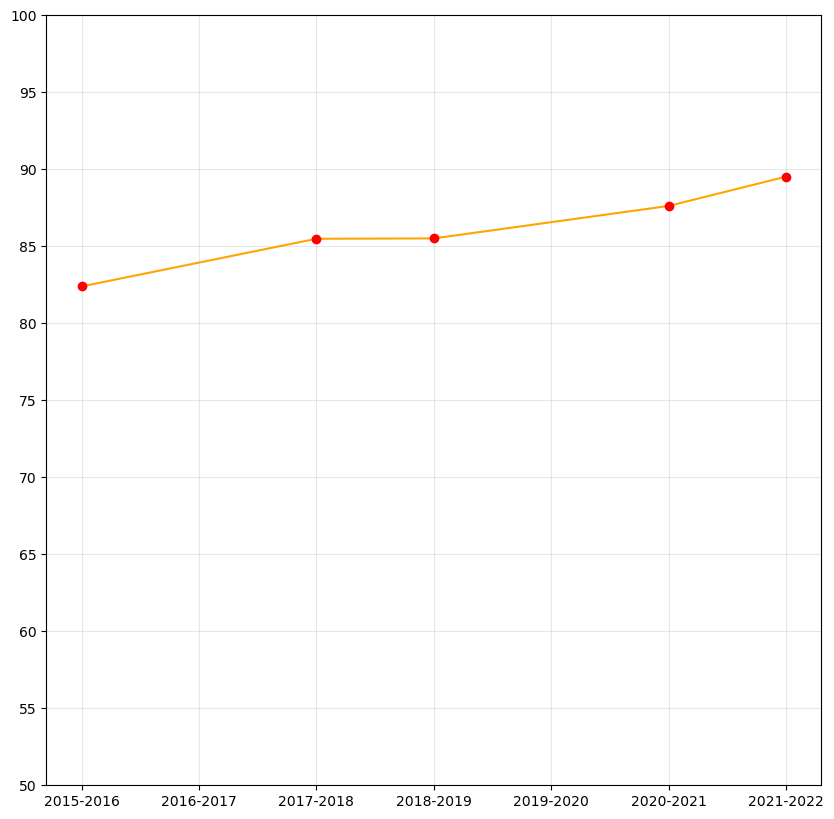

In [11]:
values1 = [percentuale_1516, (percentuale_1718+percentuale_1516)/2, percentuale_1718, percentuale_1819, (percentuale_2021+percentuale_1819)/2, percentuale_2021, percentuale_2122]
values2 = [percentuale_1516, None, percentuale_1718, percentuale_1819, None, percentuale_2021, percentuale_2122]
plt.figure(figsize=(10,10))
plt.ylim([50, 100])

plt.plot(years_labels, values1, linestyle='-', color='orange')
plt.plot(years_labels, values2, marker='o', color='red', linestyle="None")
plt.grid(alpha=0.3)
plt.yticks(np.arange(50, 105, 5))

In [12]:
print(len(get_elementari(elenco_scuole)) / len(elenco_scuole) * 100)
print(len(get_medie(elenco_scuole)) / len(elenco_scuole) * 100)
print(len(get_superiori(elenco_scuole)) / len(elenco_scuole) * 100)

38.19849874895746
25.24816431993982
19.21862990400497


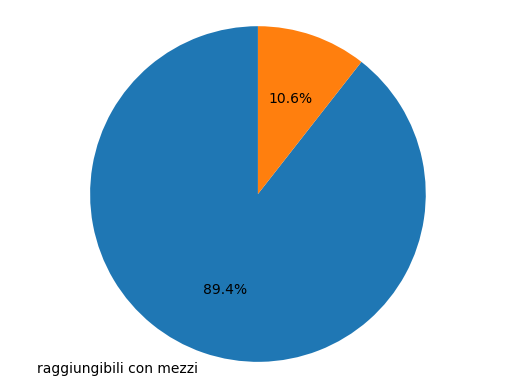

In [13]:
labels = 'raggiungibili con mezzi', ' '
percentuale = len(get_scuole_1mezzo(get_scuole_di_interesse(t_2122))) / len(get_scuole_di_interesse(t_2122)) * 100
sizes = [percentuale, 100-percentuale]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Scuole raggiunte dallo scuolabus

In [14]:
scuole_scuolabus = t_2122[t_2122.SCUOLABUS == 'SI']

elementari_scuolabus = get_elementari(scuole_scuolabus)
medie_scuolabus = get_medie(scuole_scuolabus)
superiori_scuolabus = get_superiori(scuole_scuolabus)

In [15]:
percentuali_scuolabus = [
    len(elementari_scuolabus) / len(get_elementari(t_2122)) * 100,
    len(medie_scuolabus) / len(get_medie(t_2122)) * 100,
    len(superiori_scuolabus) / len(get_superiori(t_2122)) * 100
]
percentuale_scuolabus = len(get_scuole_di_interesse(scuole_scuolabus)) / len(get_scuole_di_interesse(t_2122)) * 100

### Scuole raggiunte da trasporti pubblici urbani

In [16]:
scuole_urbano = t_2122[t_2122.TRASPORTIPUBBLICIURBANI == 'SI']

elementari_urbano = get_elementari(scuole_urbano)
medie_urbano = get_medie(scuole_urbano)
superiori_urbano = get_superiori(scuole_urbano)

In [17]:
percentuali_urbano = [
    len(elementari_urbano) / len(get_elementari(t_2122)) * 100,
    len(medie_urbano) / len(get_medie(t_2122)) * 100,
    len(superiori_urbano) / len(get_superiori(t_2122)) * 100
]

percentuale_urbano = len(get_scuole_di_interesse(scuole_urbano)) / len(get_scuole_di_interesse(t_2122)) * 100

### Scuole raggiunte da trasporti pubblici Interurbani

In [18]:
scuole_interurbano = t_2122[t_2122.TRASPORTIPUBBLICIINTERURBANI == 'SI']

elementari_interurbano = get_elementari(scuole_interurbano)
medie_interurbano = get_medie(scuole_interurbano)
superiori_interurbano = get_superiori(scuole_interurbano)

In [19]:
percentuali_interurbano = [
    len(elementari_interurbano) / len(get_elementari(t_2122)) * 100,
    len(medie_interurbano) / len(get_medie(t_2122)) * 100,
    len(superiori_interurbano) / len(get_superiori(t_2122)) * 100
]

percentuale_interurbano = len(get_scuole_di_interesse(scuole_interurbano)) / len(get_scuole_di_interesse(t_2122)) * 100

### Scuole raggiunte da trasporti ferroviari

In [20]:
scuole_ferroviario = t_2122[t_2122.TRASPORTIFERROVIARI == 'SI']

elementari_ferroviario = get_elementari(scuole_ferroviario)
medie_ferroviario = get_medie(scuole_ferroviario)
superiori_ferroviario = get_superiori(scuole_ferroviario)

In [21]:
percentuali_ferroviario = [
    len(elementari_ferroviario) / len(get_elementari(t_2122)) * 100,
    len(medie_ferroviario) / len(get_medie(t_2122)) * 100,
    len(superiori_ferroviario) / len(get_superiori(t_2122)) * 100
]

percentuale_ferroviario = len(get_scuole_di_interesse(scuole_ferroviario)) / len(get_scuole_di_interesse(t_2122)) * 100

### Barchart

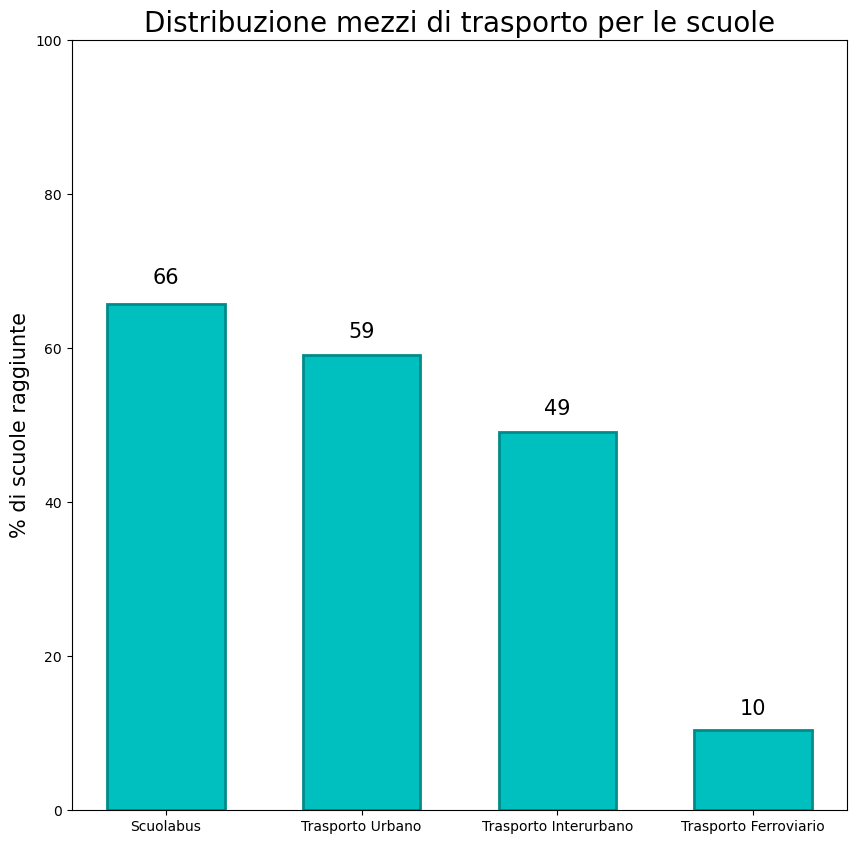

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

plt.ylim([0, 100])

def autolabel(rects):
    for rect in rects:
        height = round(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 10),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=15)



mezzi_labels = ['Scuolabus', 'Trasporto Urbano', 'Trasporto Interurbano', 'Trasporto Ferroviario']
percentuali = [percentuale_scuolabus, percentuale_urbano, percentuale_interurbano, percentuale_ferroviario]
plt.title('Distribuzione mezzi di trasporto per le scuole', fontsize=20)
plt.ylabel("% di scuole raggiunte", fontsize=15)

bars = plt.bar(mezzi_labels, percentuali, 0.6, color='c', edgecolor='darkcyan', linewidth=2)
#ax.bar_label(bars)
autolabel(bars)

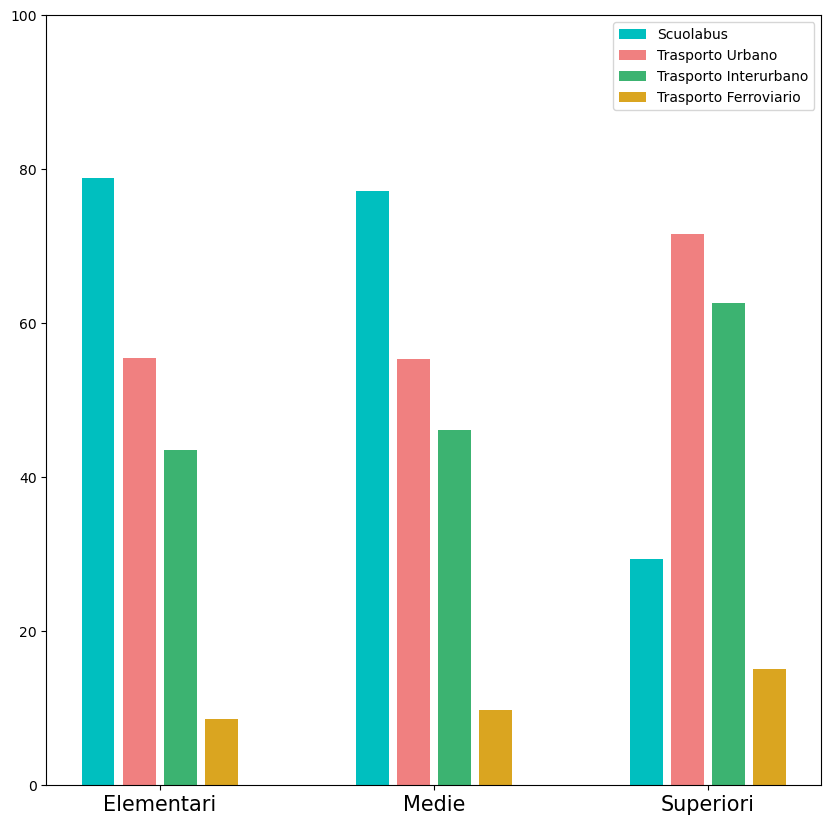

In [23]:
plt.figure(figsize=(10,10))
plt.ylim([0, 100])
width = 0.15
indexes = np.arange(3)
plt.bar(indexes, percentuali_scuolabus, 0.12, color='c', label='Scuolabus')
plt.bar(indexes + width, percentuali_urbano, 0.12, color='lightcoral', label='Trasporto Urbano')
plt.bar(indexes + width*2, percentuali_interurbano, 0.12, color='mediumseagreen', label='Trasporto Interurbano')
plt.bar(indexes + width*3, percentuali_ferroviario, 0.12, color='goldenrod', label='Trasporto Ferroviario')

plt.xticks(indexes + width*1.5, tipi_scuole_labels, fontsize = 15)
plt.legend()

# Cartine

## Cartina 1 Mezzo

In [24]:
def get_1mezzo_by_region(regione):
    codici_scuola_regione = get_scuole_by_region(regione, elenco_scuole, elenco_province).CODICESCUOLA.to_numpy()
    codici_scuola_regione_1mezzo = [x for x in codici_scuola_regione if x in codici_scuola_1mezzo]
    if(len(codici_scuola_regione) == 0): return 0
    return len(codici_scuola_regione_1mezzo) / len(codici_scuola_regione) * 100

cartina(get_1mezzo_by_region, plt.cm.coolwarm, 6, shape_regioni, '% Scuole raggiunte da almeno un mezzo')



NameError: name 'codici_scuola_1mezzo' is not defined

### Cartina scuolabus

In [ ]:
def get_scuolabus_by_region(regione):
    codici_scuola_regione = get_scuole_by_region(regione, elenco_scuole, elenco_province).CODICESCUOLA.to_numpy()
    if(len(codici_scuola_regione) == 0): return 0
    codici_scuola_scuolabus = t_2122[t_2122.SCUOLABUS == 'SI'].CODICESCUOLA.to_numpy()
    codici_scuola_regione_scuolabus = [x for x in codici_scuola_regione if x in codici_scuola_scuolabus]
    return len(codici_scuola_regione_scuolabus) / len(codici_scuola_regione) * 100

cartina(get_scuolabus_by_region, plt.cm.coolwarm, 6, shape_regioni, '% Scuole raggiunte da almeno un mezzo')



### Cartina urbano

In [ ]:
def get_urbano_by_region(regione):
    codici_scuola_regione = get_scuole_by_region(regione, elenco_scuole, elenco_province).CODICESCUOLA.to_numpy()
    if(len(codici_scuola_regione) == 0): return 0
    codici_scuola_urbano = t_2122[t_2122.TRASPORTIPUBBLICIURBANI == 'SI'].CODICESCUOLA.to_numpy()
    codici_scuola_regione_urbano = [x for x in codici_scuola_regione if x in codici_scuola_urbano]
    return len(codici_scuola_regione_urbano) / len(codici_scuola_regione) * 100

cartina(get_urbano_by_region, plt.cm.coolwarm, 6, shape_regioni, '% Scuole raggiunte da almeno un mezzo')



### Cartina interurbano

In [ ]:
def get_interurbano_by_region(regione):
    codici_scuola_regione = get_scuole_by_region(regione, elenco_scuole, elenco_province).CODICESCUOLA.to_numpy()
    if(len(codici_scuola_regione) == 0): return 0
    codici_scuola_interurbano = t_2122[t_2122.TRASPORTIPUBBLICIINTERURBANI == 'SI'].CODICESCUOLA.to_numpy()
    codici_scuola_regione_interurbano = [x for x in codici_scuola_regione if x in codici_scuola_interurbano]
    return len(codici_scuola_regione_interurbano) / len(codici_scuola_regione) * 100

cartina(get_interurbano_by_region, plt.cm.coolwarm, 6, shape_regioni, '% Scuole raggiunte da almeno un mezzo')



### Cartina ferroviario

In [ ]:
def get_ferroviario_by_region(regione):
    codici_scuola_regione = get_scuole_by_region(regione, elenco_scuole, elenco_province).CODICESCUOLA.to_numpy()
    if(len(codici_scuola_regione) == 0): return 0
    codici_scuola_ferroviario = t_2122[t_2122.TRASPORTIFERROVIARI == 'SI'].CODICESCUOLA.to_numpy()
    codici_scuola_regione_ferroviario = [x for x in codici_scuola_regione if x in codici_scuola_ferroviario]
    return len(codici_scuola_regione_ferroviario) / len(codici_scuola_regione) * 100

cartina(get_ferroviario_by_region, plt.cm.coolwarm, 6, shape_regioni, '% Scuole raggiunte da almeno un mezzo')



### Linechart campania


In [ ]:
def get_1mezzo_by_region_year(regione, codici_scuola_1mezzo, scuole_annata):
    codici_scuola_regione = get_scuole_by_region(regione, elenco_scuole, elenco_province).CODICESCUOLA.to_numpy()
    codici_annata = scuole_annata.CODICESCUOLA.to_numpy()
    codici_scuola_regione = [ x for x in codici_scuola_regione if x in codici_annata]
    codici_scuola_regione_1mezzo = [x for x in codici_scuola_regione if x in codici_scuola_1mezzo]
    if(len(codici_scuola_regione) == 0): return 0
    return len(codici_scuola_regione_1mezzo) / len(codici_scuola_regione) * 100


campania_1516 = get_1mezzo_by_region_year('Campania', codici_scuola_1mezzo_1516, t_1516)
campania_1718 = get_1mezzo_by_region_year('Campania', codici_scuola_1mezzo_1718, t_1718)
campania_1819 = get_1mezzo_by_region_year('Campania', codici_scuola_1mezzo_1819, t_1819)
campania_2021 = get_1mezzo_by_region_year('Campania', codici_scuola_1mezzo_2021, t_2021)
campania_2122 = get_1mezzo_by_region_year('Campania', codici_scuola_1mezzo_2122, t_2122)

lines = [
    campania_1516, 
    (campania_1718+campania_1516)/2, 
    campania_1718, campania_1819, 
    (campania_2021+campania_1819)/2, 
    campania_2021, campania_2122
]
dots = [
    campania_1516, 
    None, 
    campania_1718, 
    campania_1819, 
    None, 
    campania_2021, 
    campania_2122
]

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim([50, 100])

plt.plot(years_labels, lines, linestyle='-', color='orange')
plt.plot(years_labels, dots, marker='o', color='red', linestyle="None")
plt.grid(alpha=0.3)
plt.yticks(np.arange(50, 105, 5))

# Ambiente

INTRODUZIONE:
I seguenti punti sono rilevanti per determinare la vivibilità dell'ambiente in cui è inserita la scuola; oltre al tema della salute, legata principalmente agli agenti inquinanti, gli elementi di disturbo come traffico, transiti ferroviari e in generali fonti di inquinamento acustico possono essere determinanti per l'effettiva vivibilità dell'ambiente durante le lezioni e durante i momenti di svago.

- vicinanza discarica
- vicinanza industrie inquinanti
- vicinanza acque inquinate
- vicinanza fonti inquinamento atmosferico
- vicinanza fonti di inquinamento acustico
- vicinanza fonti di radiazioni elettro magnetiche
- presenza grande traffico 
- presenza transito ferroviario
- presenza industrie a rischio

GRAFICI:
- 1: istogramma in cui per ogni categoria si dicono le percentuali di scuole che sono vicini a quella cosa, in modo da individuare l'elemento negativo più presente vicino alle scuole (non ha senso andare a vedere l'andamento negli anni, perché credo siano cose che non cambiano in pochi anni; sarebbe sensato se avessimo i dati di 20 anni forse )
- 2: cartina delle regioni in cui per ogni elemento inquinante mettiamo la percentuale di scuole, così da vedere per esempio in che zona dell'italia sono maggiormente presenti industrie inquinanti vicino alle scuole, in che zona d'italia sono maggiormente presenti altri tipi di fonti inquinanti ecc. -> in questo modo creiamo delle mappe di distribuzione degli agenti inquinanti, il che potrebbe essere molto interessante.
- 3: cartina in cui per ogni regione vediamo la percentuale media di vicinanze, cioè per ogni scuola il numero di cose a cui è vicina, facciamo la media e quindi infine abbiamo per ogni regione un indice di qualità dell'ambiente ( da 0 a 11, dove 0 significa che le scuole sono mediamente vicine a 0 fonti inquinanti, e 11 significa che le scuole sono mediamente vicine a 11 fonti inquinanti diverse); da questa cartina possiamo scegliere quella peggiore e usarla come caso critico

REGIONE CRITICA:
- 4: possiamo fare una sorta di infografica in cui mettiamo insieme i dati ricavati dalle cartine precedenti, ovvero per la regione scelta la percentuale di scuole vicine ad una certa fonte di inquinamento, ecc., così da avere un quadro riassuntivo per quella regione.
- 5: Potenzialmente possiamo fare un discorso provinciale, quindi fare la cartina della percentuale media delle vicinanze per vedere se la situazione varia al variare delle province; se notiamo delle differenze allora potremmo anche fare le cartine in cui vediamo per ogni agente inquinante come è distribuito nelle province, anche se così diventa lungo, potremmo farlo solo per alcuni, magari quelli la cui percentuale è maggiore (tipo sappiamo che per la regione A, una percentuale altissima di scuole è vicina ad un agente inquinante B, allora possiamo vedere la situazione a livello provinciale, e quindi vedere per ogni provincia la percentuale di scuole vicine all'agente inquinante B)

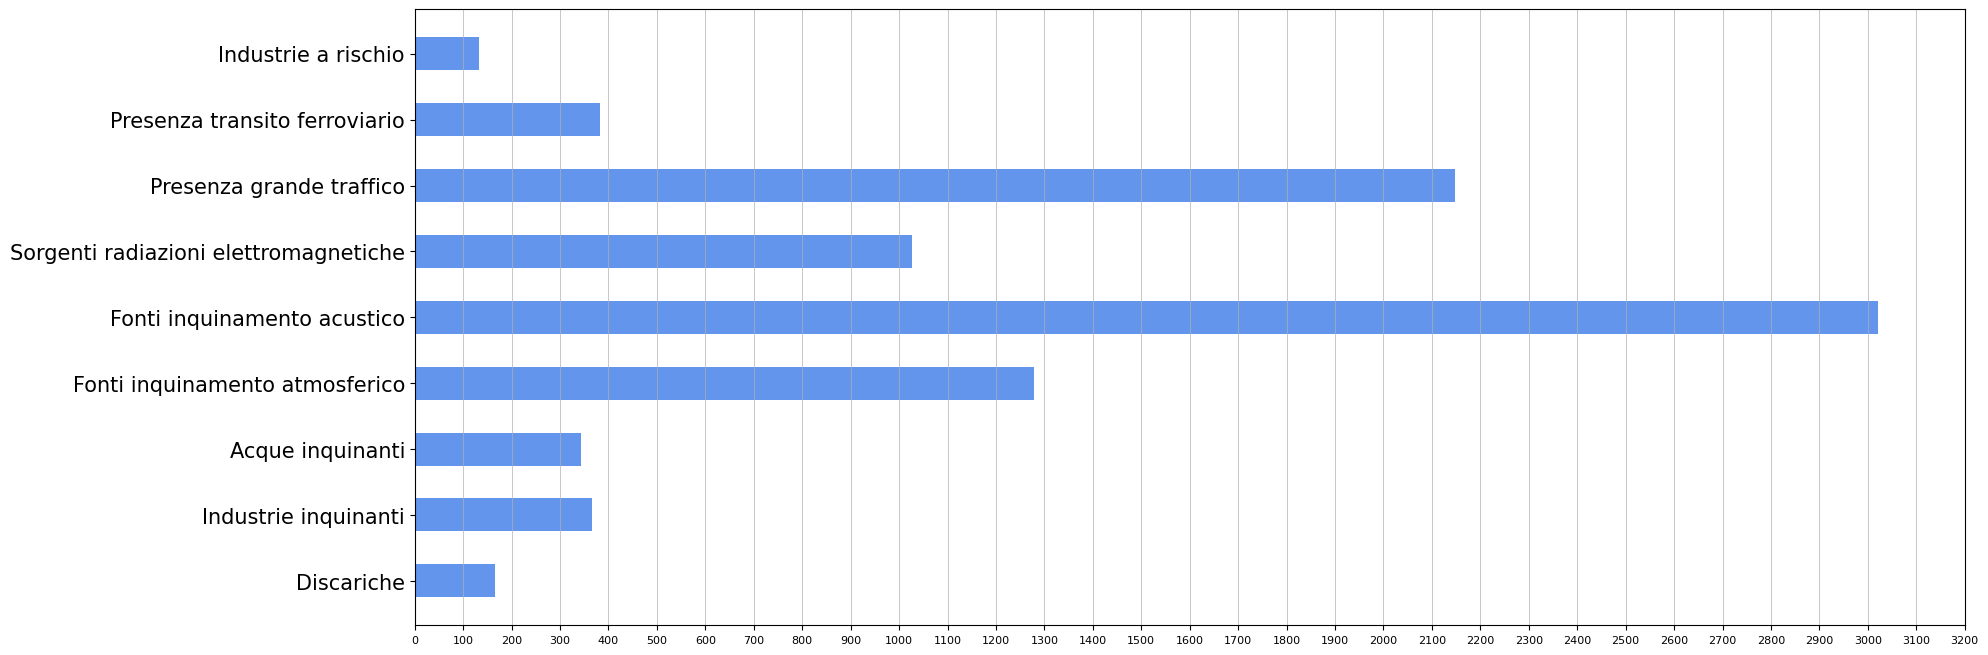

In [190]:
a_2122 = get_scuole_di_interesse(a_2122)

labels = [
    'Discariche',
    'Industrie inquinanti',
    'Acque inquinanti',
    'Fonti inquinamento atmosferico',
    'Fonti inquinamento acustico',
    'Sorgenti radiazioni elettromagnetiche',
    'Presenza grande traffico',
    'Presenza transito ferroviario',
    'Industrie a rischio'
]

values = [
    len(a_2122[a_2122.VICINANZADISCARICA == 'SI']),
    len(a_2122[a_2122.VICINANZAINDUSTRIEINQUINANTI == 'SI']),
    len(a_2122[a_2122.VICINANZAACQUEINQUINANTI == 'SI']),
    len(a_2122[a_2122.VICINANZAFONTIINQUINAMENTOATMOSFERICO == 'SI']),
    len(a_2122[a_2122.VICINANZAFONTIINQUINAMENTOACUSTICO == 'SI']),
    len(a_2122[a_2122.VICINANZASORGENTIRADIAZIONIELETTROMAGNETICHE == 'SI']),
    len(a_2122[a_2122.PRESENZAGRANDETRAFFICO == 'SI']),
    len(a_2122[a_2122.PRESENZATRANSITOFERROVIARIO == 'SI']),
    len(a_2122[a_2122.VICINANZAINDUSTRIEARISCHIO == 'SI'])
]


percentuali = [
    len(a_2122[a_2122.VICINANZADISCARICA == 'SI']) / len(a_2122) * 100,
    len(a_2122[a_2122.VICINANZAINDUSTRIEINQUINANTI == 'SI']) / len(a_2122) * 100,
    len(a_2122[a_2122.VICINANZAACQUEINQUINANTI == 'SI']) / len(a_2122) * 100,
    len(a_2122[a_2122.VICINANZAFONTIINQUINAMENTOATMOSFERICO == 'SI']) / len(a_2122) * 100,
    len(a_2122[a_2122.VICINANZAFONTIINQUINAMENTOACUSTICO == 'SI']) / len(a_2122) * 100,
    len(a_2122[a_2122.VICINANZASORGENTIRADIAZIONIELETTROMAGNETICHE == 'SI']) / len(a_2122) * 100,
    len(a_2122[a_2122.PRESENZAGRANDETRAFFICO == 'SI']) / len(a_2122) * 100,
    len(a_2122[a_2122.PRESENZATRANSITOFERROVIARIO == 'SI']) / len(a_2122) * 100,
    len(a_2122[a_2122.VICINANZAINDUSTRIEARISCHIO == 'SI']) / len(a_2122) * 100
]

plt.figure(figsize=(20, 8))
bars = plt.barh(labels, values, height=0.5, color='cornflowerblue')
plt.xticks(np.arange(0, 3300, 100), fontsize=8)
plt.yticks(fontsize=15)
plt.grid(linewidth=0.5, axis='x')

def autolabel(rects):
    for rect in rects:
        height = round(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 10),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=15)

autolabel(bars)




# Barriere architettoniche

Categorie:
- Accorgimenti presenti in generale ( i dati successivi sono presenti solo se questa è a si )

- accesso esterno con rampe
- Ascensore per il trasporto disabili
- Servoscala piattaforma elevatrice
- servizi igienici per disabili


GRAFICI:
- barchart categorie servizi
- 1: Linechart in cui per ogni servizi indichiamo la percentuale di scuole che lo offrono; così identifichiamo i servizi meno diffusi e quindi critici, e se queste percentuali sono cambiate nel tempo.
- 2: cartina in cui per ogni regione calcoliamo la percentuale di scuole che in generale hanno accorgimenti 
- 3: potremmo fare una cartina per ogni servizio (magari non per tutti, per i principali, tipo accesso con rampe, servo scala o ascensore e servizi igienici) oppure magari una cartina in cui mettiamo la percentuale di scuole che hanno un set "base" (tipo rampe + ascensore o servoscala e servizi) di accorgimenti, e sulla base di quest'ultima scegliamo la regione critica

- pie-chart

REGIONE CRITICA:
- 4: linechart in cui vediamo se la percentuale di scuole che presenta il set base di accorgimenti è variato nel tempo
- 5: cartina a livello provinciale, per vedere se la carenza è localizzata o generale.


Problematicità: come trattiamo i non definiti? li includiamo nel totale? io li includerei come no; è vero che bisognerebbe dare il beneficio del dubbio, ma volendo dichiarare quante scuole, secondo i dati, presentano questi servizi, il non definito mi pare più un no che un si; il motivo per cui è non definito è una problematica relativa alla raccolta dei dati.
Quindi le percentuali le farei SI / SI + NO + NON DEFINITO
Comunque durante la presentazione dovremmo far presente di questa cosa e giustificare la scelta fatta
